# Table S1-2

In [1]:
import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.metrics
from statsmodels.sandbox.stats.multicomp import get_tukey_pvalue
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.oneway import anova_oneway

In [2]:
def anova_with_report(data):
    # One way ANOVA, helper function for formatting
    control = scipy.stats.f_oneway(*data)
    print(control)
    a = anova_oneway(
        data,
        use_var="equal",
    )
    assert np.isclose(a.pvalue, control.pvalue), (a.pvalue, control.pvalue)
    assert np.isclose(a.statistic, control.statistic)
    return f"F = {a.statistic}, p = {a.pvalue}\n\n    " + "\n    ".join(
        str(a).split("\n")
    )

In [3]:
DATA = "../data/SupplTable1.h5"

## Table S1: Consistency across subjects

We compare the consistency across subjects of all available methods depicted in Figure 1:

In [4]:
methods = [
    "cebra_10_b",
    "cebra_10_t",
    "pivae_10_w",
    "pivae_10_wo",
    "tsne",
    "umap",
    "autolfads",
]

In [5]:
def subject_consistency(key):
    if key == "autolfads":
        autolfads_consistency = np.array(
            [
                [0.52405768, 0.54354575, 0.5984262],
                [0.61116595, 0.59024053, 0.747014],
                [0.68505602, 0.60948229, 0.57858312],
                [0.77841349, 0.78809085, 0.65031025],
            ]
        )
        return autolfads_consistency.flatten()
    else:
        data = (
            pd.read_hdf(DATA, key=key)
            .pivot_table(
                "train", columns="animal", aggfunc=lambda v: np.mean(np.array(v))
            )
            .agg(np.concatenate, axis=1)
            .item()
        )
        return data


def load_data(keys):
    return pd.DataFrame(
        [{"method": key, "metric": subject_consistency(key)} for key in keys]
    )


# Subject Consistency

Anova:  F_onewayResult(statistic=25.454720289784103, pvalue=1.9171102662989993e-16)

Post Hoc test:

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
  autolfads  cebra_10_b    0.301    0.0  0.1549  0.4472   True
  autolfads  cebra_10_t    0.129 0.1192 -0.0171  0.2752  False
  autolfads  pivae_10_w   0.1049 0.3219 -0.0412  0.2511  False
  autolfads pivae_10_wo  -0.1111 0.2569 -0.2572  0.0351  False
  autolfads        tsne   0.0369 0.9876 -0.1092   0.183  False
  autolfads        umap  -0.2312 0.0002 -0.3774 -0.0851   True
 cebra_10_b  cebra_10_t   -0.172 0.0108 -0.3181 -0.0258   True
 cebra_10_b  pivae_10_w  -0.1961 0.0021 -0.3423   -0.05   True
 cebra_10_b pivae_10_wo  -0.4121    0.0 -0.5582  -0.266   True
 cebra_10_b        tsne  -0.2641    0.0 -0.4103  -0.118   True
 cebra_10_b        umap  -0.5323    0.0 -0.6784 -0.3861 

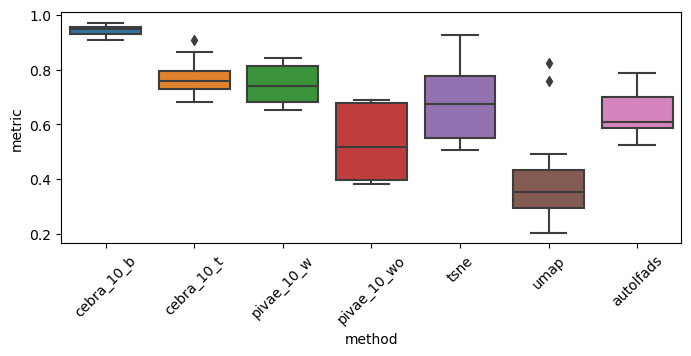

In [6]:
data = load_data(methods)
anova_sup = scipy.stats.f_oneway(*data.metric.values)
data_explode = data.explode("metric")
data_explode.metric = data_explode.metric.astype(float)
data_explode.sort_values("metric")
posthoc_sup = pairwise_tukeyhsd(
    data_explode.metric.values, data_explode.method.values, alpha=0.05
)

print(
    f"""
# Subject Consistency

Anova:  {anova_sup}

Post Hoc test:

{posthoc_sup}
p-values: {posthoc_sup.pvalues}
"""
)

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
sns.boxplot(data=data.explode("metric"), x="method", y="metric", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

## Table S2: Decoding performance

We compare the methods trained using label information (CEBRA-behavior and all considered variants of piVAE) and the self-/un-supervised methods trained without using labels (CEBRA-time, t-SNE, UMAP, autoLFADS, and the PCA baseline).

In [7]:
supervised_methods = [
    "cebra_10_b",
    "pivae_1_w",
    "pivae_10_w",
    "pivae_1_wo",
    "pivae_10_wo",
]
supervised_methods_decoding = [
    "cebra_10_b",
    "pivae_1_mcmc",
    "pivae_10_mcmc",
    "pivae_1_wo",
    "pivae_10_wo",
]
unsupervised_methods = ["cebra_10_t", "tsne", "umap", "autolfads", "pca"]

In [8]:
# for decoding
# avg over seeds
#    (# animals x # of CV runs) --> 4 x 3 --> 12


def decoding(key, animal=0):
    data = pd.read_hdf(DATA, key=key)
    metric = "test_position_error"
    if metric + "_svm" in data.columns:
        metric = metric + "_svm"
    data = data.pivot_table(
        metric, index="animal", columns="seed", aggfunc=lambda v: np.mean(np.array(v))
    ).agg(np.array, axis=1)

    if animal is None:
        return data.agg(np.concatenate, axis=0)
    else:
        return data.loc[animal]


def load_data(keys, animal):
    return pd.DataFrame(
        [{"method": key, "metric": decoding(key, animal)} for key in keys]
    ).copy()


def report_supervised(animal):
    data = load_data(supervised_methods_decoding, animal)
    anova = anova_with_report(data.metric.values)
    data_explode = data.explode("metric")
    data_explode.metric = data_explode.metric.astype(float)
    posthoc_sup = pairwise_tukeyhsd(
        data_explode.metric.values, data_explode.method.values, alpha=0.05
    )
    return anova, posthoc_sup, data


def report_unsupervised(animal):
    data = load_data(unsupervised_methods, animal)
    data.loc[(data["method"] == "pca"), "metric"] = data[(data["method"] == "pca")][
        "metric"
    ].apply(lambda v: v.repeat(10))
    data_explode = data.explode("metric")
    data_explode.metric = data_explode.metric.astype(float)
    anova = anova_with_report(data.metric.values)
    posthoc = pairwise_tukeyhsd(
        data_explode.metric.values, data_explode.method.values, alpha=0.05
    )
    return anova, posthoc_sup, data


def plot_overview(sup_data, unsup_data):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    sns.boxplot(data=sup_data.explode("metric"), x="method", y="metric", ax=axes[0])
    sns.boxplot(data=unsup_data.explode("metric"), x="method", y="metric", ax=axes[1])
    axes[0].set_title("Supervised")
    axes[1].set_title("Unsupervised")
    for ax in axes:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.tight_layout()
    plt.show()

### Rat 1 (Achilles), Anova and post-hoc test on supervised methods

In [9]:
anova, posthoc, sup_data = report_supervised(0)

print(anova)
print("\n\n")
print(posthoc)
print("p-values: ", ", ".join(map(str, posthoc.pvalues)))

F_onewayResult(statistic=130.8489167329169, pvalue=3.584864370350153e-24)
F = 130.84891673291744, p = 3.584864370349843e-24

    statistic = 130.84891673291744
    pvalue = 3.584864370349843e-24
    df = (4.0, 45.0)
    df_num = 4.0
    df_denom = 45.0
    nobs_t = 50.0
    n_groups = 5
    means = [0.05458863 0.12718886 0.11124251 0.35219591 0.16122803]
    nobs = [10. 10. 10. 10. 10.]
    vars_ = [4.48646101e-06 7.35450406e-05 8.94713254e-04 8.68539373e-04
         3.07831069e-03]
    use_var = equal
    welch_correction = True
    tuple = (130.84891673291744, 3.584864370349843e-24)



       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
   cebra_10_b pivae_10_mcmc   0.0567 0.0018  0.0168 0.0965   True
   cebra_10_b   pivae_10_wo   0.1066    0.0  0.0668 0.1465   True
   cebra_10_b  pivae_1_mcmc   0.0726    0.0  0.0327 0.1125   True
   cebra_

### Rat 1 (Achilles), Anova and post-hoc test on unsupervised methods

In [10]:
anova, posthoc, unsup_data = report_unsupervised(0)

print(anova)
print("\n\n")
print(posthoc)
print("p-values: ", ", ".join(map(str, posthoc.pvalues)))

F_onewayResult(statistic=1983.0064715111755, pvalue=5.950793013875487e-50)
F = 1983.006471511298, p = 5.950793013867255e-50

    statistic = 1983.006471511298
    pvalue = 5.950793013867255e-50
    df = (4.0, 45.0)
    df_num = 4.0
    df_denom = 45.0
    nobs_t = 50.0
    n_groups = 5
    means = [0.04710335 0.06233259 0.05585373 0.06659485 0.22385401]
    nobs = [10. 10. 10. 10. 10.]
    vars_ = [1.49161239e-06 4.27979600e-07 4.56283808e-07 1.37750285e-04
         0.00000000e+00]
    use_var = equal
    welch_correction = True
    tuple = (1983.006471511298, 5.950793013867255e-50)



     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
  autolfads  cebra_10_b    0.301    0.0  0.1549  0.4472   True
  autolfads  cebra_10_t    0.129 0.1192 -0.0171  0.2752  False
  autolfads  pivae_10_w   0.1049 0.3219 -0.0412  0.2511  False
  autolfads pivae_10_wo  -0.1

### Rat 1 (Achilles), overview plot

(Not shown in the paper)

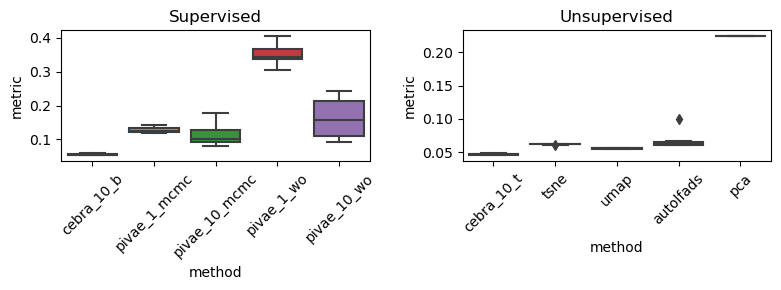

In [11]:
plot_overview(sup_data, unsup_data)

### All Rats, Anova and post-hoc test on supervised methods

In [12]:
anova, posthoc, sup_data = report_supervised(None)

print(anova)
print("\n\n")
print(posthoc)
print("p-values: ", ", ".join(map(str, posthoc.pvalues)))

F_onewayResult(statistic=55.17031672006308, pvalue=4.694077971736457e-31)
F = 55.170316720063056, p = 4.694077971736618e-31

    statistic = 55.170316720063056
    pvalue = 4.694077971736618e-31
    df = (4.0, 195.0)
    df_num = 4.0
    df_denom = 195.0
    nobs_t = 200.0
    n_groups = 5
    means = [0.13529156 0.30867451 0.14618708 0.40349386 0.2895263 ]
    nobs = [40. 40. 40. 40. 40.]
    vars_ = [0.00385949 0.01914409 0.00143575 0.00413979 0.01880184]
    use_var = equal
    welch_correction = True
    tuple = (55.170316720063056, 4.694077971736618e-31)



       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
   cebra_10_b pivae_10_mcmc   0.0109 0.9872  -0.049 0.0708  False
   cebra_10_b   pivae_10_wo   0.1542    0.0  0.0943 0.2142   True
   cebra_10_b  pivae_1_mcmc   0.1734    0.0  0.1134 0.2333   True
   cebra_10_b    pivae_1_wo   0.268

### All Rats, Anova and post-hoc test on unsupervised methods

In [13]:
anova, posthoc, unsup_data = report_unsupervised(None)

print(anova)
print("\n\n")
print(posthoc)
print("p-values: ", ", ".join(map(str, posthoc.pvalues)))

F_onewayResult(statistic=14.746848806860859, pvalue=1.523730417925221e-10)
F = 14.746848806860855, p = 1.523730417925221e-10

    statistic = 14.746848806860855
    pvalue = 1.523730417925221e-10
    df = (4.0, 195.0)
    df_num = 4.0
    df_denom = 195.0
    nobs_t = 200.0
    n_groups = 5
    means = [0.11689811 0.1959747  0.18944162 0.24828243 0.30024827]
    nobs = [40. 40. 40. 40. 40.]
    vars_ = [0.00354796 0.01188905 0.01183249 0.02293898 0.01386443]
    use_var = equal
    welch_correction = True
    tuple = (14.746848806860855, 1.523730417925221e-10)



     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
  autolfads  cebra_10_b    0.301    0.0  0.1549  0.4472   True
  autolfads  cebra_10_t    0.129 0.1192 -0.0171  0.2752  False
  autolfads  pivae_10_w   0.1049 0.3219 -0.0412  0.2511  False
  autolfads pivae_10_wo  -0.1111 0.2569 -0.2572  0.0

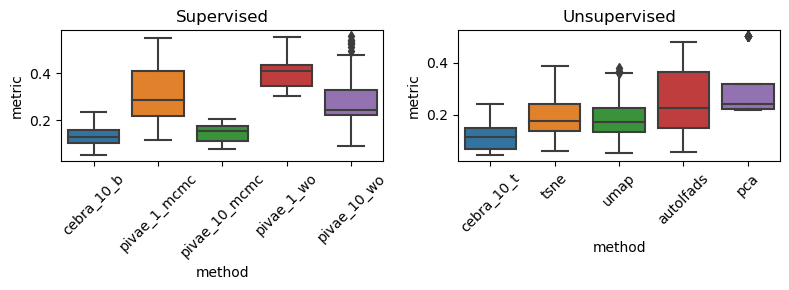

In [14]:
plot_overview(sup_data, unsup_data)

### Overview of the decoding performance

In [15]:
rat = 0
print(f"Rat {rat}")
for key in supervised_methods_decoding:
    print(
        f"\t{key}\t{decoding(key, animal=rat).mean():.5f} +/- {decoding(key, animal=rat).std():.5f}"
    )

Rat 0
	cebra_10_b	0.05459 +/- 0.00201
	pivae_1_mcmc	0.12719 +/- 0.00814
	pivae_10_mcmc	0.11124 +/- 0.02838
	pivae_1_wo	0.35220 +/- 0.02796
	pivae_10_wo	0.16123 +/- 0.05264
